# STYLE-ALIGNED WITH PROMPTS ONLY

In [1]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAlignedDiffModels.git

# Change directory to the cloned repository
%cd StyleAlignedDiffModels
%ls

# Set up Git configuration
!git config --global user.name "Alessio Borgi"
!git config --global user.email "alessioborgi3@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

fatal: destination path 'StyleAlignedDiffModels' already exists and is not an empty directory.
/content/StyleAlignedDiffModels
imgs/              requirements.txt               StyleAligned_Explanation.ipynb
inversion.py       sa_handler.py                  StyleAligned_with_Prompts_only.ipynb
LICENSE            sa_handler_try.py              StyleAligned_with_Reference.ipynb
pipeline_calls.py  src/                           TO-DO.txt
README.md          StyleAligned_ControlNet.ipynb


In [2]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

In [3]:
from __future__ import annotations
import copy
import torch
import einops
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL

from src.Handler import Handler
from src.StyleAlignedArgs import StyleAlignedArgs

T = torch.tensor # Create Alias for torch.tensor to increase readability.
TN = T

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
scheduler_linear = DDIMScheduler(
    beta_start=0.00085,                 # Starting value of beta
    beta_end=0.012,                     # Ending value of beta
    beta_schedule="scaled_linear",      # Type of schedule for beta values
    clip_sample=False,                  # Whether to clip samples to a specified range
    set_alpha_to_one=False,             # Whether to set alpha to one at the end of the process

    num_train_timesteps=1000,           # Number of diffusion steps used during training
    timestep_spacing="linspace",        # Method to space out timesteps
    prediction_type="epsilon",          # Type of prediction model used in the scheduler
    trained_betas=None                  # Optional pre-trained beta values
)

scheduler = scheduler_linear

In [5]:
SDXL_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0",  # The model name or path
    torch_dtype=torch.float16,            # Data type for the model's tensors
    variant="fp16",                       # Model variant for 16-bit floating point precision (Mixed Precision)
    use_safetensors=True,                 # Use the safetensors library for safe tensor loading
    scheduler=scheduler,                  # Scheduler instance for the diffusion process

    revision=None,                        # Model version to use, default is None
    use_auth_token=None,                  # Authentication token, None means no authentication
    cache_dir=None,                       # Directory to cache the downloaded model, None uses default
    force_download=False,                 # Force download even if the model exists locally
    resume_download=False,                # Resume a partial download if available
    proxies=None,                         # Dictionary of proxy servers to use, None means no proxies
    local_files_only=False,               # Use only local files if set to True
    device_map=None,                      # Device placement for model layers, None uses default placement
    max_memory=None                       # Maximum memory allowed for each device, None means no specific limit
).to("cuda")                              # Move the model to the GPU for faster computations

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Keyword arguments {'use_auth_token': None} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
handler = Handler(SDXL_Pipeline)
sa_args = StyleAlignedArgs(share_group_norm=False,
                                      share_layer_norm=False,
                                      share_attention=True,
                                      adain_queries=True,
                                      adain_keys=True,
                                      adain_values=False
                                     )

handler.register(sa_args)

  0%|          | 0/50 [00:00<?, ?it/s]

,,,

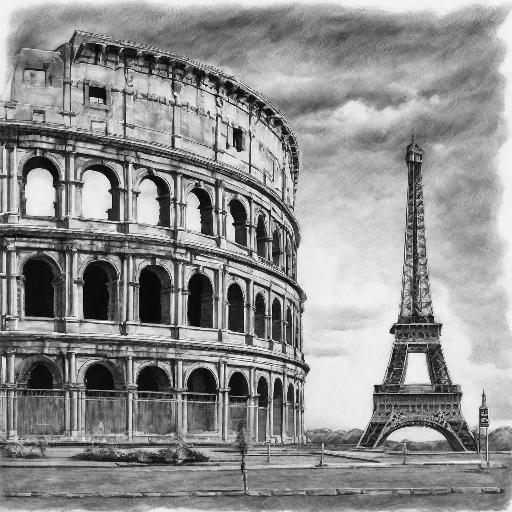
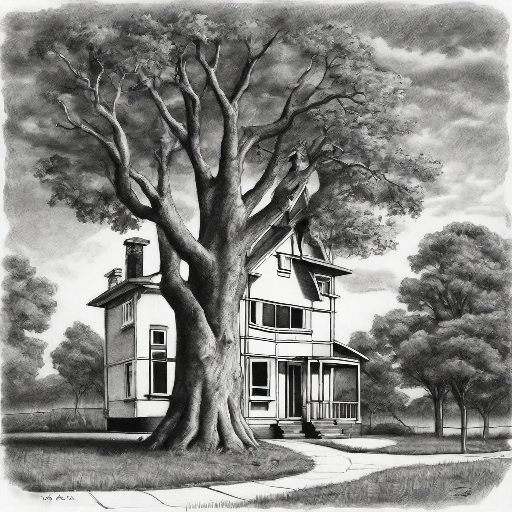
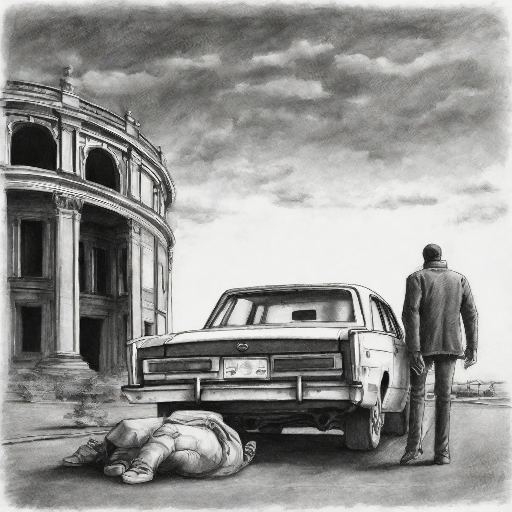
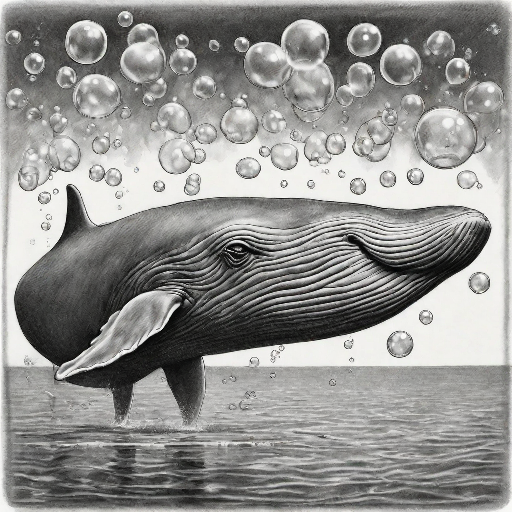

In [7]:
# run StyleAligned

sets_of_prompts = [
  "The colosseum next to the eiffel tower. Pencil drawing.",
  "A house next to a tree. Pencil drawing.",
  "A car next to a person. Pencil drawing.",
  "A whale next to a beam of bubbles. Pencil drawing.",
]
images = SDXL_Pipeline(sets_of_prompts,).images
mediapy.show_images(images)